In [1]:
from intake import open_catalog
import numpy as np
import xarray as xr
import xgcm
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from dask.distributed import Client, progress
from dask_gateway import Gateway

gateway = Gateway()
cluster = gateway.new_cluster()
cluster.scale(12)
cluster

In [3]:
client = Client(cluster)
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.4527b8497d484adc97d44b1da656c773 Dashboard: /services/dask-gateway/clusters/prod.4527b8497d484adc97d44b1da656c773/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


#### This analysis is based on the 1-year output of a channel model by Balwada et al. (2018) and Abernathey et al. (2011).
- Three resolutions (20 km, 5 km, and 1 km) are used to compare roles of eddies in the ACC.
- Balwada, D., Smith, K. S., & Abernathey, R. (2018). Submesoscale vertical velocities enhance tracer subduction in an idealized Antarctic Circumpolar Current. Geophysical Research Letters, 45(18), 9790-9802.
- Abernathey, R., Marshall, J., & Ferreira, D. (2011). The dependence of Southern Ocean meridional overturning on wind stress. Journal of Physical Oceanography, 41(12), 2261-2278.

In [4]:
# Load data
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/channel.yaml")
ds1  = cat["channel_ridge_resolutions_20km"].to_dask()
ds2  = cat["channel_ridge_resolutions_05km"].to_dask()
ds3  = cat["channel_ridge_resolutions_01km"].to_dask()

grid1 = xgcm.Grid(ds1)
grid2 = xgcm.Grid(ds2)
grid3 = xgcm.Grid(ds3)

#### Temperature snapshot

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/plot/plot.py:945: UserWarning: The following kwargs were not used by contour: 'vmim'
  primitive = ax.contourf(x, y, z, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/plot/plot.py:945: UserWarning: The following kwargs were not used by contour: 'vmim'
  primitive = ax.contourf(x, y, z, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/plot/plot.py:945: UserWarning: The following kwargs were not used by contour: 'vmim'
  primitive = ax.contourf(x, y, z, **kwargs)


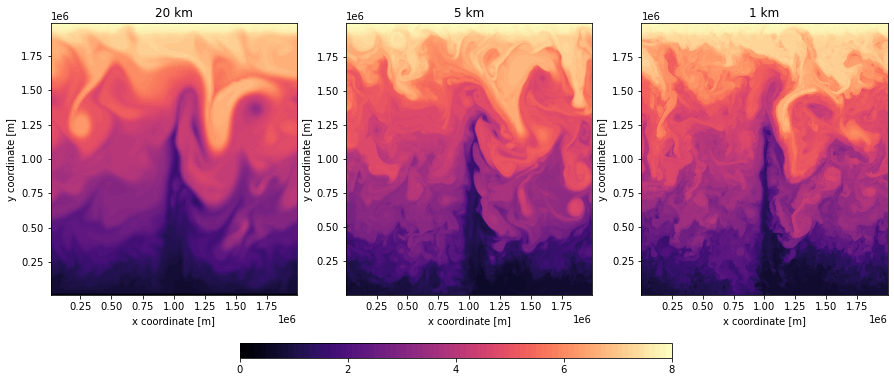

In [21]:
levt = np.arange(0, 8.01, 0.1)

fig = plt.figure(figsize=(15, 5))

plt.subplot(131)
h1 = ds1.T[-1, 0, :, :].plot.contourf(levels=levt, cmap='magma', vmim=0, vmax=8, add_colorbar=False)

plt.title('20 km')

plt.subplot(132)
ds2.T[-1, 0, :, :].plot.contourf(levels=levt, cmap='magma', vmim=0, vmax=8, add_colorbar=False)

plt.title('5 km')

plt.subplot(133)
ds3.T[-1, 0, :, :].plot.contourf(levels=levt, cmap='magma', vmim=0, vmax=8, add_colorbar=False)

plt.title('1 km')

c_ticks = np.arange(0, 8.01, 2)
cbar_ax = fig.add_axes([0.3, -0.05, 0.4, 0.04])
hc = fig.colorbar(h1, cax=cbar_ax, orientation='horizontal', ticks=c_ticks)

#### Surface EKE

In [9]:
u_mean1 = ds1.U.mean('time')
v_mean1 = ds1.V.mean('time')

vp1 = ds1.V - v_mean1
up1 = ds1.U - u_mean1

# ----------
u_mean2 = ds2.U.mean('time')
v_mean2 = ds2.V.mean('time')

vp2 = ds2.V - v_mean2
up2 = ds2.U - u_mean2

# ----------
u_mean3 = ds3.U.mean('time')
v_mean3 = ds3.V.mean('time')

vp3 = ds3.V - v_mean3
up3 = ds3.U - u_mean3

In [13]:
eke1 = np.sqrt(up1[:, 0, :, :].values**2 + vp1[:, 0, :, :].values**2)
eke2 = np.sqrt(up2[:, 0, :, :].values**2 + vp2[:, 0, :, :].values**2)
eke3 = np.sqrt(up3[:, 0, :, :].values**2 + vp3[:, 0, :, :].values**2)

Text(0.5, 1.0, '$cm^2/s^2$')

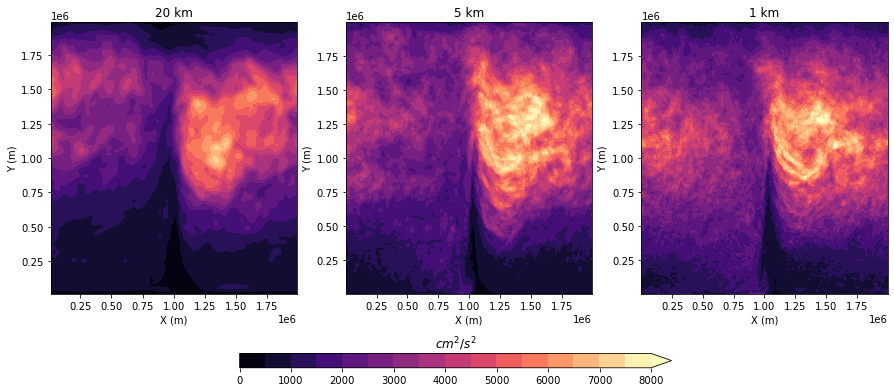

In [31]:
levt = np.arange(0, 8001, 500)

fig = plt.figure(figsize=(15, 5))

plt.subplot(131)
h1 = plt.contourf(ds1.XC, ds1.YC, eke1.mean(axis=0)*1e4, levels=levt, cmap='magma', extend='max')

plt.title('20 km')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(132)
h1 = plt.contourf(ds2.XC, ds2.YC, eke2.mean(axis=0)*1e4, levels=levt, cmap='magma', extend='max')

plt.title('5 km')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(133)
h1 = plt.contourf(ds3.XC, ds3.YC, eke3.mean(axis=0)*1e4, levels=levt, cmap='magma', extend='max')

plt.title('1 km')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

#c_ticks = np.arange(-1, 1.01, 0.2)
cbar_ax = fig.add_axes([0.3, -0.08, 0.4, 0.04])
hc = fig.colorbar(h1, cax=cbar_ax, orientation='horizontal')
plt.title(r'$cm^2/s^2$')

#### Zonally averaged EKE

Text(0, 0.5, 'Y (m)')

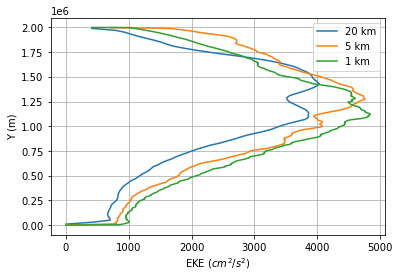

In [37]:
plt.plot(eke1.mean(axis=0).mean(axis=1)*1e4, ds1.YC, label='20 km')
plt.plot(eke2.mean(axis=0).mean(axis=1)*1e4, ds2.YC, label='5 km')
plt.plot(eke3.mean(axis=0).mean(axis=1)*1e4, ds3.YC, label='1 km')
plt.grid()
plt.legend()
plt.xlabel(r'EKE ($cm^2/s^2$)')
plt.ylabel('Y (m)')

- The EKE value in 5-km case is similar to that in 1-km case.

#### Time-mean of SSH

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/plot/plot.py:945: UserWarning: The following kwargs were not used by contour: 'vmim'
  primitive = ax.contourf(x, y, z, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/plot/plot.py:945: UserWarning: The following kwargs were not used by contour: 'vmim'
  primitive = ax.contourf(x, y, z, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/plot/plot.py:945: UserWarning: The following kwargs were not used by contour: 'vmim'
  primitive = ax.contourf(x, y, z, **kwargs)


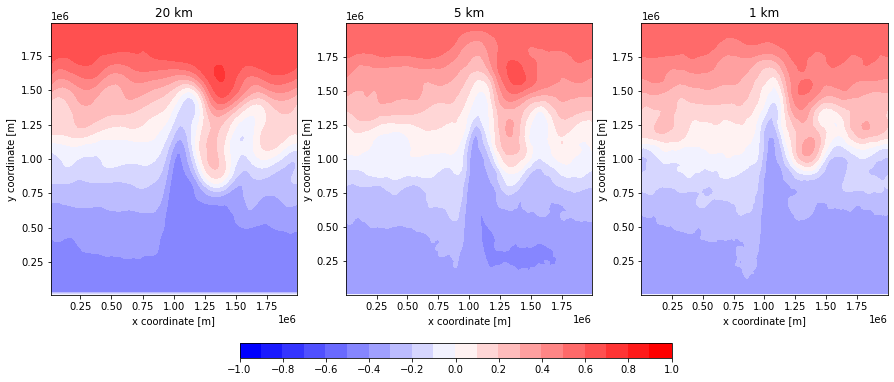

In [29]:
levt = np.arange(-1, 1.01, 0.1)

fig = plt.figure(figsize=(15, 5))

plt.subplot(131)
h1 = ds1.Eta.mean('time').plot.contourf(levels=levt, cmap='bwr', vmim=-1, vmax=1, add_colorbar=False)

plt.title('20 km')

plt.subplot(132)
ds2.Eta.mean('time').plot.contourf(levels=levt, cmap='bwr', vmim=-1, vmax=1, add_colorbar=False)

plt.title('5 km')

plt.subplot(133)
ds3.Eta.mean('time').plot.contourf(levels=levt, cmap='bwr', vmim=-1, vmax=1, add_colorbar=False)

plt.title('1 km')

c_ticks = np.arange(-1, 1.01, 0.2)
cbar_ax = fig.add_axes([0.3, -0.05, 0.4, 0.04])
hc = fig.colorbar(h1, cax=cbar_ax, orientation='horizontal', ticks=c_ticks)

#### Zonally averaged temperature

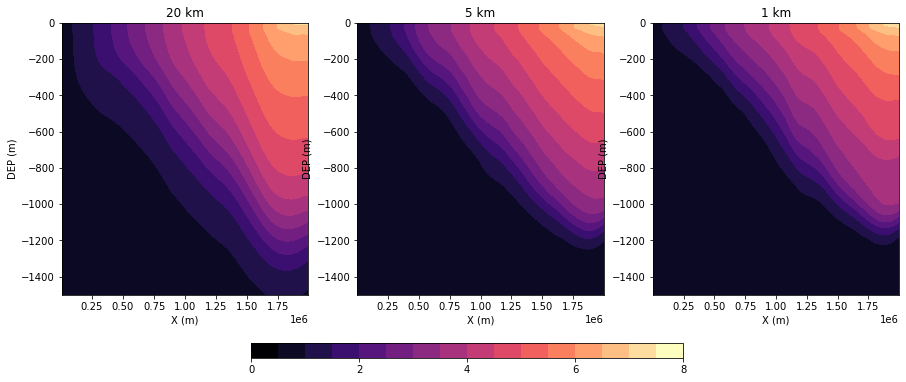

In [9]:
levt1 = np.arange(0, 8.1, 0.5)
levt2 = np.arange(0, 8.1, 1)

fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
h1 = ds1.T.mean(['time','XC']).plot.contourf(cmap='magma', levels=levt1, add_colorbar=False)
#ds1.T.mean(['time','XC']).plot.contour(colors='w', levels=levt2)
plt.ylim(-1500, 0)
plt.xlabel('X (m)')
plt.ylabel('DEP (m)')
plt.title('20 km')

plt.subplot(132)
ds2.T.mean(['time','XC']).plot.contourf(cmap='magma', levels=levt1, add_colorbar=False)
#ds2.T.mean(['time','XC']).plot.contour(colors='w', levels=levt2)
plt.ylim(-1500, 0)
plt.xlabel('X (m)')
plt.ylabel('DEP (m)')
plt.title('5 km')

plt.subplot(133)
ds3.T.mean(['time','XC']).plot.contourf(cmap='magma', levels=levt1, add_colorbar=False)
#ds3.T.mean(['time','XC']).plot.contour(colors='w', levels=levt2)
plt.ylim(-1500, 0)
plt.xlabel('X (m)')
plt.ylabel('DEP (m)')
plt.title('1 km')

c_ticks = np.arange(0, 8.01, 2)
cbar_ax = fig.add_axes([0.3, -0.05, 0.4, 0.04])
hc = fig.colorbar(h1, cax=cbar_ax, orientation='horizontal', ticks=c_ticks)

#### Zonally averaged velocity
- colors are velocity
- black lines are temperature

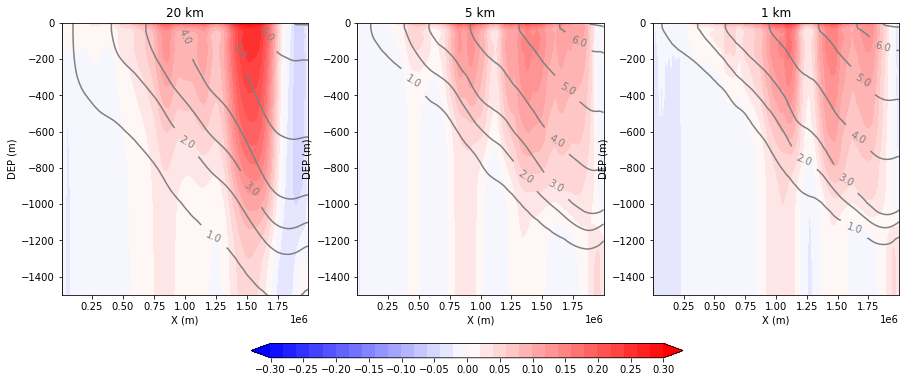

In [14]:
lev1 = np.arange(-0.3, 0.31, 0.02)

fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
h1 = ds1.U.mean(['time','XG']).plot.contourf(cmap='bwr', levels=lev1, add_colorbar=False, extend='both')
h2 = ds1.T.mean(['time','XC']).plot.contour(colors='gray', levels=np.arange(0, 8.01, 1))
plt.clabel(h2, fontsize=10, fmt='%2.1f')

plt.ylim(-1500, 0)
plt.xlabel('X (m)')
plt.ylabel('DEP (m)')
plt.title('20 km')

plt.subplot(132)
ds2.U.mean(['time','XG']).plot.contourf(cmap='bwr', levels=lev1, add_colorbar=False, extend='both')
h2 = ds2.T.mean(['time','XC']).plot.contour(colors='gray', levels=np.arange(0, 8.01, 1))
plt.clabel(h2, fontsize=10, fmt='%2.1f')

plt.ylim(-1500, 0)
plt.xlabel('X (m)')
plt.ylabel('DEP (m)')
plt.title('5 km')

plt.subplot(133)
ds3.U.mean(['time','XG']).plot.contourf(cmap='bwr', levels=lev1, add_colorbar=False, extend='both')
h2 = ds3.T.mean(['time','XC']).plot.contour(colors='gray', levels=np.arange(0, 8.01, 1))
plt.clabel(h2, fontsize=10, fmt='%2.1f')

plt.ylim(-1500, 0)
#plt.xlabel('X (m)')
plt.xlabel('X (m)')
plt.ylabel('DEP (m)')
plt.title('1 km')

c_ticks = np.arange(-0.3, 0.31, 0.05)
cbar_ax = fig.add_axes([0.3, -0.05, 0.4, 0.04])
hc = fig.colorbar(h1, cax=cbar_ax, orientation='horizontal', ticks=c_ticks)

#### Eddy heat transport
$ Q = \overline{v'T'} $

In [6]:
t_mean1 = ds1.T.mean('time')
v_mean1 = ds1.V.mean('time')

tp1 = ds1.T - t_mean1
vp1 = ds1.V - v_mean1

# ----------
t_mean2 = ds2.T.mean('time')
v_mean2 = ds2.V.mean('time')

tp2 = ds2.T - t_mean2
vp2 = ds2.V - v_mean2

# ----------
t_mean3 = ds3.T.mean('time')
v_mean3 = ds3.V.mean('time')

tp3 = ds3.T - t_mean3
vp3 = ds3.V - v_mean3

In [18]:
vptp1 = tp1 * grid1.interp(vp1, axis='Y')

vptp2 = tp2 * grid2.interp(vp2, axis='Y')

vptp3 = tp3 * grid3.interp(vp3, axis='Y')

In [25]:
vptp3_var = np.zeros((76, 2000))

for i in np.arange(76):
    vptp3_var[i, :] = vptp3[:, i, :, :].mean(['time', 'XC']).values

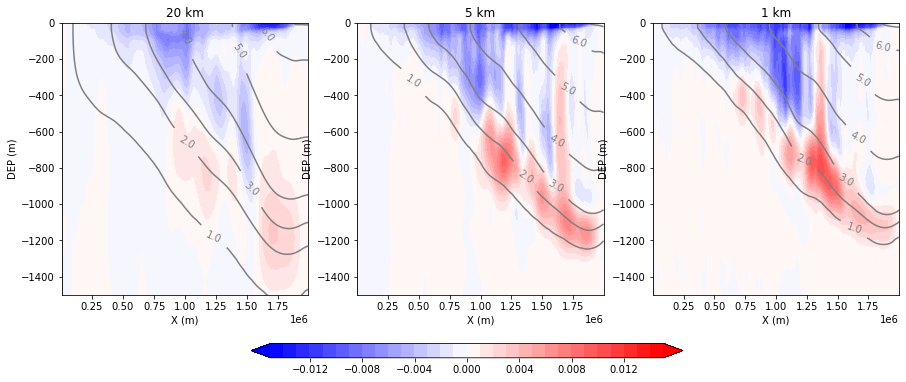

In [29]:
lev = np.arange(-0.015, 0.0151, 0.001)
fig = plt.figure(figsize=(15, 5))

plt.subplot(131)
h1 = vptp1.mean(['time', 'XC']).plot.contourf(levels=lev, extend='both', add_colorbar=False, cmap='bwr')
h2 = ds1.T.mean(['time','XC']).plot.contour(colors='gray', levels=np.arange(0, 8.01, 1))
plt.clabel(h2, fontsize=10, fmt='%2.1f')

plt.ylim(-1500, 0)

plt.title('20 km')
plt.xlabel('X (m)')
plt.ylabel('DEP (m)')

plt.subplot(132)
vptp2.mean(['time', 'XC']).plot.contourf(levels=lev, extend='both', add_colorbar=False, cmap='bwr')
h2 = ds2.T.mean(['time','XC']).plot.contour(colors='gray', levels=np.arange(0, 8.01, 1))
plt.clabel(h2, fontsize=10, fmt='%2.1f')

plt.ylim(-1500, 0)

plt.title('5 km')
plt.xlabel('X (m)')
plt.ylabel('DEP (m)')

plt.subplot(133)
#vptp3.mean('time').plot.contourf(levels=lev, extend='both', add_colorbar=False, cmap='bwr')
h1 = plt.contourf(ds3.XC, ds3.Z, vptp3_var, levels=lev, extend='both', cmap='bwr')
h2 = ds3.T.mean(['time','XC']).plot.contour(colors='gray', levels=np.arange(0, 8.01, 1))
plt.clabel(h2, fontsize=10, fmt='%2.1f')

plt.ylim(-1500, 0)

plt.title('1 km')
plt.xlabel('X (m)')
plt.ylabel('DEP (m)')

cbar_ax = fig.add_axes([0.3, -0.05, 0.4, 0.04])
hc = fig.colorbar(h1, cax=cbar_ax, orientation='horizontal')

#### Vertical eddy heat transport

In [5]:
t_mean1 = ds1.T.mean('time')
w_mean1 = ds1.W.mean('time')

tp1 = ds1.T - t_mean1
wp1 = ds1.W - w_mean1

# ----------
t_mean2 = ds2.T.mean('time')
w_mean2 = ds2.W.mean('time')

tp2 = ds2.T - t_mean2
wp2 = ds2.W - w_mean2

# ----------
t_mean3 = ds3.T.mean('time')
w_mean3 = ds3.W.mean('time')

tp3 = ds3.T - t_mean3
wp3 = ds3.W - w_mean3

In [6]:
wptp1 = tp1 * grid1.interp(wp1, axis='Z')

wptp2 = tp2 * grid2.interp(wp2, axis='Z')

wptp3 = tp3 * grid3.interp(wp3, axis='Z')

In [7]:
wptp3_var = np.zeros((76, 2000))

for i in np.arange(76):
    wptp3_var[i, :] = wptp3[:, i, :, :].mean(['time', 'XC']).values

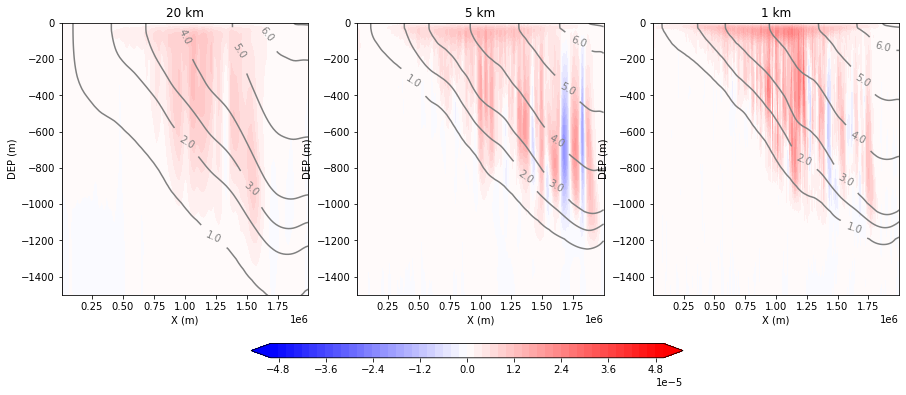

In [9]:
lev = np.arange(-5e-5, 5e-5, 2e-6)
fig = plt.figure(figsize=(15, 5))

plt.subplot(131)
h1 = wptp1.mean(['time', 'XC']).plot.contourf(levels=lev, extend='both', add_colorbar=False, cmap='bwr')
h2 = ds1.T.mean(['time','XC']).plot.contour(colors='gray', levels=np.arange(0, 8.01, 1))
plt.clabel(h2, fontsize=10, fmt='%2.1f')

plt.ylim(-1500, 0)

plt.title('20 km')
plt.xlabel('X (m)')
plt.ylabel('DEP (m)')

plt.subplot(132)
wptp2.mean(['time', 'XC']).plot.contourf(levels=lev, extend='both', add_colorbar=False, cmap='bwr')
h2 = ds2.T.mean(['time','XC']).plot.contour(colors='gray', levels=np.arange(0, 8.01, 1))
plt.clabel(h2, fontsize=10, fmt='%2.1f')

plt.ylim(-1500, 0)

plt.title('5 km')
plt.xlabel('X (m)')
plt.ylabel('DEP (m)')

plt.subplot(133)
#vptp3.mean('time').plot.contourf(levels=lev, extend='both', add_colorbar=False, cmap='bwr')
h1 = plt.contourf(ds3.XC, ds3.Z, wptp3_var, levels=lev, extend='both', cmap='bwr')
h2 = ds3.T.mean(['time','XC']).plot.contour(colors='gray', levels=np.arange(0, 8.01, 1))
plt.clabel(h2, fontsize=10, fmt='%2.1f')

plt.ylim(-1500, 0)

plt.title('1 km')
plt.xlabel('X (m)')
plt.ylabel('DEP (m)')

cbar_ax = fig.add_axes([0.3, -0.05, 0.4, 0.04])
hc = fig.colorbar(h1, cax=cbar_ax, orientation='horizontal')